In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


In [2]:
# reading the file from a path and list the field names and input columns of interest
path = 'data/adult.data'


def reading_data(path):
    your_data_df = pd.read_csv(path)
    all_columns = np.array(your_data_df.columns)
    print('Columns in your data are:\n ',all_columns)
    all_columns = set(all_columns.tolist())
    #print(type(all_columns))
    
    return your_data_df, all_columns

your_data_df, all_columns = reading_data(path)

Columns in your data are:
  ['39' ' State-gov' ' 77516' ' Bachelors' ' 13' ' Never-married'
 ' Adm-clerical' ' Not-in-family' ' White' ' Male' ' 2174' ' 0' ' 40'
 ' United-States' ' <=50K']


In [3]:
# TODO: use 'input_from_user'
valid_input = False
while valid_input == False:
    answer = input('Which column is your output (prediction, estimation etc.)?:')
    if answer not in all_columns:
        print('Please enter a valid column')
    else:
        valid_input = True

output_field = answer
print("Your prediction column is '{}'".format(output_field))


Which column is your output (prediction, estimation etc.)?: <=50K
Your prediction column is ' <=50K'


In [4]:
def input_from_user(input_str, warn_str, result_str, possible_set):
    
    valid_input = False
    while valid_input == False:
        answer = input(input_str)
        if answer not in possible_set:
            print(warn_str)
        else:
            valid_input = True
    print(result_str+"'{}'".format(answer))
    return answer

In [5]:
possible_set = set(your_data_df[output_field].unique())
print("Your prediction column possible values '{}'".format(possible_set))
print('Please enter two different labels in the output field: ')

input_str = 'Enter label 0:'
warn_str = 'Please enter a valid lable within output field'
result_str = "Your output label 0 is "
output_label0 = input_from_user(input_str, warn_str, result_str, possible_set)

possible_set.remove(output_label0)

input_str = 'Enter label 1:'
warn_str = 'Please enter a valid lable within output field'
result_str = "Your output label 1 is "
output_label1 = input_from_user(input_str, warn_str, result_str, possible_set)

Your prediction column possible values '{' >50K', ' <=50K'}'
Please enter two different labels in the output field: 
Enter label 0: <=50K
Your output label 0 is ' <=50K'
Enter label 1: >50K
Your output label 1 is ' >50K'


In [6]:
# TODO: use 'input_from_user'
valid_input = False
while valid_input == False:
    answer = input('Which column is your sensitive attribute?:')
    if answer not in all_columns or answer == output_field:
        print('Please enter a valid column, cannot be the same with prediction column')
    else:
        valid_input = True

sensitive_field = answer
print("Your sensitive attribute column is '{}'".format(sensitive_field))




Which column is your sensitive attribute?: Male
Your sensitive attribute column is ' Male'


In [7]:
possible_set = set(your_data_df[sensitive_field].unique())


print('unique values from the sensitive class:{}'.format(possible_set))
print('Please enter two different classes in the sensisitve field: ')

input_str = 'Enter class 0:'
warn_str = 'Please enter a valid class within sensitive field'
result_str = "Your sensitive attribute class 0 is "
sensitive_class0 = input_from_user(input_str, warn_str, result_str, possible_set)

possible_set.remove(sensitive_class0)

input_str = 'Enter class 1:'
warn_str = 'Please enter a valid class within sensitive field'
result_str = "Your sensitive attribute class 1 is "
sensitive_class1 = input_from_user(input_str, warn_str, result_str, possible_set)

unique values from the sensitive class:{' Female', ' Male'}
Please enter two different classes in the sensisitve field: 
Enter class 0: Male
Your sensitive attribute class 0 is ' Male'
Enter class 1: Female
Your sensitive attribute class 1 is ' Female'


In [8]:
# TODO: use 'input_from_user'
valid_input = False
while valid_input == False:
    answer = input('Do you want to omit any column from your data? Please enter Y or N:')
    if answer not in ['Y','N']:
        print('Please enter Y or N')
    else:
        valid_input = True

fields_to_delete = answer


Do you want to omit any column from your data? Please enter Y or N:Y


In [9]:
columns_can_omitted = set(all_columns)
columns_can_omitted.remove(output_field)


In [10]:
if fields_to_delete == 'Y':
    
    not_to_consider_fields = []
    valid_input = False
    no_more = False


    while (valid_input == False) or (no_more == False):
        answer = input('Enter a column, you want to omit or enter "no more" if you are done:')


        if answer == 'no more':
            valid_input = True
            no_more = True
        else:
            if answer not in columns_can_omitted:
                print('Not a valid column')
                #answer = input('Enter a column, you want to omit or enter "no more" if you are done:')
            else:
                valid_input = True
                #no_more = False
                not_to_consider_field = answer
                not_to_consider_fields.append(not_to_consider_field) 
                
    print('Columns to be omitted: {}'.format(not_to_consider_fields))
else:
    print('All columns are kept.')

Enter a column, you want to omit or enter "no more" if you are done: White
Enter a column, you want to omit or enter "no more" if you are done:no more
Columns to be omitted: [' White']


In [11]:
def processing_data_frame(output_field, sensitive_field, your_data_df, not_to_consider_fields,class0,class1):
    
    #drop columns
    for item in not_to_consider_fields:
        if item != sensitive_field:
            your_data_df = your_data_df.drop(item, axis=1)
            #print(item,'----',sensitive_field)
           # print(item,your_data_df.columns)
    
    #check for missing values, do sth with them
    your_data_df = your_data_df.dropna()
    
    # only keep the row with sensitive field equal to class1, and class2
    your_data_df = your_data_df.loc[lambda df: df[sensitive_field].isin([class0, class1])]

    #create Y
    Y_df = your_data_df[output_field]
    
    #create Z
    Z_df = your_data_df[sensitive_field]
    
    #create X
    X_df = your_data_df.copy()
    #print(X_df.shape)
    X_df = X_df.drop(output_field, axis=1)
    #print(X_df.shape)


    if sensitive_field in not_to_consider_fields:
        X_df = X_df.drop(sensitive_field, axis=1)
        
       
    
    return X_df, Y_df, Z_df
    
X_df, Y_df, Z_df = processing_data_frame(output_field, sensitive_field, your_data_df, not_to_consider_fields,sensitive_class0,sensitive_class1)    
 

X_df.shape

(32560, 13)

In [12]:
print('output field:{}'.format(output_field))
print('output field:{} Label 0-1 {}, {}'.format(output_field,output_label0,output_label1 ))
print('sensitive field:{} Class 0-1 {}, {}'.format(sensitive_field,sensitive_class0,sensitive_class1 ))
print('not to consider fields',not_to_consider_fields)

output field: <=50K
output field: <=50K Label 0-1  <=50K,  >50K
sensitive field: Male Class 0-1  Male,  Female
not to consider fields [' White']


### starting here I want to omit Pandas series and frames

In [13]:
# for now X stays pandas

### First let's see how biased your data:

In [14]:
def bias_checker_p_rule_bin(Z, Y):
    
    
    Y_Z_class0 = Y[Z == 0]
    Y0_Z_class0 = Y_Z_class0[Y_Z_class0 == 0]
    Y1_Z_class0 = Y_Z_class0[Y_Z_class0 == 1]

    Y_Z_class1 = Y[Z == 1]
    Y0_Z_class1 = Y_Z_class1[Y_Z_class1 == 0]
    Y1_Z_class1 = Y_Z_class1[Y_Z_class1 == 1]
    
    Y0Z0 = (Y0_Z_class0.shape[0])
    Y1Z0 = (Y1_Z_class0.shape[0])
    Z0 = Y0Z0 + Y1Z0
    
    Y0Z1 = (Y0_Z_class1.shape[0])
    Y1Z1 = (Y1_Z_class1.shape[0])
    Z1 = Y0Z1 + Y1Z1

    
    p_rule_for_Y0 = format(100*min([(Y0Z1/Z1)/(Y0Z0/Z0),(Y0Z0/Z0)/(Y0Z1/Z1)]),'.2f')
    p_rule_for_Y1 = format(100*min([(Y1Z1/Z1)/(Y1Z0/Z0),(Y1Z0/Z0)/(Y1Z1/Z1)]),'.2f')

    
    return p_rule_for_Y0,p_rule_for_Y1
    




In [15]:
def enforcing_binary_output_sensitive(Y_df,output_field,output_label0, output_label1,Z_df,sensitive_field,sensitive_class0, sensitive_class1):

    Ybin = (Y_df == output_label1).astype(int)
    Zbin = (Z_df == sensitive_class1).astype(int)


    return Ybin, Zbin

Ybin, Zbin = enforcing_binary_output_sensitive(Y_df,output_field,output_label0, output_label1,Z_df,sensitive_field,sensitive_class0,sensitive_class1)

p_rule_for_Y0,p_rule_for_Y1 = bias_checker_p_rule_bin(Zbin, Ybin)   

print('p_rule_for_Y1',p_rule_for_Y1)

p_rule_for_Y1 35.80


### Train test split

In [16]:
X = pd.get_dummies(X_df,drop_first=True) 
print(type(X),X.shape)
print(type(X_df),X_df.shape)

<class 'pandas.core.frame.DataFrame'> (32560, 96)
<class 'pandas.core.frame.DataFrame'> (32560, 13)


In [17]:
#X = pd.get_dummies(X_df,drop_first=True) 
Y = Ybin 
Z = Zbin
test_train_ratio = 0.5

#TODO: Can I do this in Keras?
# TODO : what should be left to the user

# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, Y, Z, test_size=test_train_ratio, 
                                                                     stratify=Y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

print(X_train.shape)
print(X_test.shape)

#X_train = np.array(X_train)
#X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(16280, 96)
(16280, 96)
(16280, 96)
(16280, 96)


### Your model

In [18]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    dense4 = Dense(32, activation="relu")(dropout3)
    dropout4 = Dropout(0.2)(dense4)
    outputs = Dense(1, activation='sigmoid')(dropout4)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [22]:
# initialise NeuralNet Classifier
main_task_ori = nn_classifier(n_features=X_train.shape[1])
main_task_ori2 = nn_classifier(n_features=X_train.shape[1])




In [24]:
print(type(main_task_ori))
print(type(main_task_ori2))
print(id(main_task_ori))
print(id(main_task_ori2))

<class 'keras.engine.training.Model'>
<class 'keras.engine.training.Model'>
112162728536
112183724072


In [ ]:
# train on train set
history = main_task_ori.fit(X_train, y_train, epochs=20, verbose=0)

In [48]:
main_task_ori.predict(X_test).ravel().shape

(16280,)

In [49]:
# predict on test set
y_pred = main_task_ori.predict(X_test).ravel()#, index=y_test.index
y_hat = (y_pred>0.5)*1

In [50]:
def main_task_performance(X_test,y_test,y_hat):

    main_task_accuracy = accuracy_score(y_test, y_hat)
    return main_task_accuracy

In [51]:
main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

p_rule_for_Y0,p_rule_for_Y1 = bias_checker_p_rule_bin(Z_test, y_hat)   

print('p_rule_for_Y1',p_rule_for_Y1)

Accuracy: 85.25
p_rule_for_Y1 29.69


### Adding adversarial net

In [34]:
# HIDE

class FairClassifier(object):
    
    def __init__(self, n_features, tradeoff_lambda):
        self.tradeoff_lambda = tradeoff_lambda
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        dense4 = Dense(32, activation="relu")(dropout3)
        dropout4 = Dropout(0.2)(dense4)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout4)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        dense4 = Dense(32, activation="relu")(dense3)
        outputs = Dense(1, activation='sigmoid')(dense4)# for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        """print('bu1')
        print(type(inputs))
        print(type(clf_net(inputs)))
        print(type([clf_net(inputs)]))
        print(type(adv_net(clf_net(inputs))))
        print(type([adv_net(clf_net(inputs))]))
        """
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+[adv_net(clf_net(inputs))])
        
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-self.tradeoff_lambda]
        
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy'], optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        class_values = [0, 1]
        class_weights = []
        
        """
        balanced_weights = compute_class_weight('balanced', class_values, data_set)
        class_weights.append(dict(zip(class_values, balanced_weights)))
        
        """
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
              
                
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, z.values, class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            save_figs=False):
        
        
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = [] #pd.DataFrame()  
        
        for idx in range(T_iter):
            print(idx)
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                
               
                self._fairness_metrics.append(bias_checker_p_rule_bin((y_pred>0.5)*1.0,z_val))
                
                display.clear_output(wait=True)

            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, z.values, batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            #self._clf_w_adv.train_on_batch(x.values[indices], 
                                           #[y.values[indices]]+[z.values[indices]])
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+[z.values[indices]],
                                           class_weight=class_weight_clf_w_adv)

In [35]:
tradeoff_lambda = 100.

#lambda_race=130
#lambda_sex=30
# initialise FairClassifier
clf = FairClassifier(n_features=X_train.shape[1],
                     tradeoff_lambda=tradeoff_lambda)


### Pre train and its results

In [36]:
#print(bu0)
# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

In [37]:

# predict on test set
y_pred = clf.predict(X_test).ravel()#, index=y_test.index
y_hat = (y_pred>0.5)*1


main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

p_rule_for_Y0,p_rule_for_Y1 = bias_checker_p_rule_bin(Z_test, y_hat)   

print('p_rule_for_Y1',p_rule_for_Y1)



Accuracy: 85.17
p_rule_for_Y1 31.32


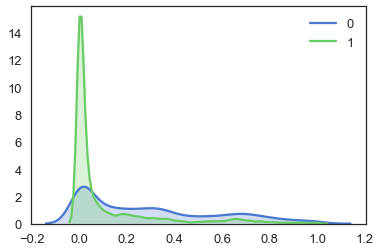

In [38]:
ax = sns.distplot(y_pred[Z_test == 0], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('0'))
ax = sns.distplot(y_pred[Z_test == 1], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('1'))

### Adversarial train and its resuls

In [39]:
# adverserial train on train set and validate on test set
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=165, save_figs=create_gif)

164


In [40]:
# predict on test set
y_pred = clf.predict(X_test).ravel()#, index=y_test.index
y_hat = (y_pred>0.5)*1


main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

p_rule_for_Y0,p_rule_for_Y1 = bias_checker_p_rule_bin(Z_test, y_hat)   

print('p_rule_for_Y1',p_rule_for_Y1)


Accuracy: 82.24
p_rule_for_Y1 99.22


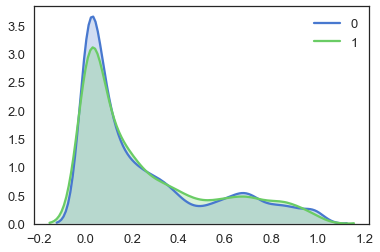

In [41]:
ax = sns.distplot(y_pred[Z_test == 0], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('0'))
ax = sns.distplot(y_pred[Z_test == 1], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('1'))